In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pypfopt import BlackLittermanModel
import warnings
warnings.filterwarnings('ignore')

In [32]:
df = pd.read_excel('/Users/matias/Desktop/Proyectos/Black_Litterman_app/Private_debt_filled.xlsx')
df = df.sort_values('Dates')
df = df.ffill()

try:
    pesos_path = '/Users/matias/Library/CloudStorage/GoogleDrive-mvilla@buenavistacapital.com/.shortcut-targets-by-id/1Lbjcks5sDTC17AftNR6mDxW8bwAA7EaA/BVC/Asset Allocation/bbdd seleccion portafolio.xlsx'
    pesos_df = pd.read_excel(pesos_path, sheet_name='Pesos', index_col=0, header=None).squeeze()
    portafolio_modelo = pesos_df.to_dict()
    print("✓ Portafolio modelo cargado desde Google Drive")
except Exception as e:
    print(f"⚠ No se pudo cargar portafolio modelo: {e}")
    portafolio_modelo = {}

✓ Portafolio modelo cargado desde Google Drive


In [33]:
pesos_df

0
USA                0.186669
Europa equities    0.033235
UK                 0.010642
Japon              0.019689
Asia               0.022409
Latam              0.006271
US IG              0.128053
US HY              0.029894
Europa bonds       0.027294
Emerging sov       0.029958
Latam corp         0.208135
ABS                0.012068
Private Equity     0.068359
Private Debt       0.125936
Commodities        0.007747
Oro                0.018873
Name: 1, dtype: float64

In [34]:
date_col = next((col for col in df.columns if col.lower() in ['fecha', 'date', 'dates']), None)
df_prices = df.drop(columns=[date_col]) if date_col else df.iloc[:, 1:]

df_prices = df_prices.dropna(how='all')
daily_returns = df_prices.pct_change()

print(f"Activos disponibles: {daily_returns.columns.tolist()}")
print(f"Período de datos: {len(daily_returns)} días")

Activos disponibles: ['SPX Index', 'MXEUG Index', 'UKX Index', 'MXJP Index', 'MXAPJ Index', 'MXLA Index', 'LF98TRUU Index', 'LUACTRUU Index', 'LBEATRUH Index', 'BSELTRUU Index', 'BSSUTRUU Index', 'CABS Index', 'BCOMTR Index', 'GLD US EQUITY', 'MXWD Index', 'Private Debt', 'Private Equity']
Período de datos: 5854 días


In [35]:
trading_days = 365
annual_returns = daily_returns.mean() * trading_days
annual_volatility = daily_returns.std() * np.sqrt(trading_days)
cov_matrix = daily_returns.cov() * trading_days

metrics = pd.DataFrame({
    'Retorno Anual (%)': annual_returns * 100,
    'Volatilidad Anual (%)': annual_volatility * 100
})
print(metrics)

                Retorno Anual (%)  Volatilidad Anual (%)
SPX Index               14.828680              17.307636
MXEUG Index              9.472730              19.479685
UKX Index                8.333514              18.589566
MXJP Index               8.940222              19.190206
MXAPJ Index              7.959857              16.261661
MXLA Index               4.690789              24.347581
LF98TRUU Index           6.496826               4.644711
LUACTRUU Index           4.029576               5.581698
LBEATRUH Index           3.259710               3.876901
BSELTRUU Index           5.414498               6.419949
BSSUTRUU Index           5.009707               5.621536
CABS Index               3.383567               2.380560
BCOMTR Index             1.197154              14.399885
GLD US EQUITY            9.613968              15.772614
MXWD Index              11.259374              14.492697
Private Debt             8.404248               2.703707
Private Equity          12.8180

In [36]:
max_deviation = 0.01


if portafolio_modelo:
    modelo_serie = pd.Series(portafolio_modelo)
    modelo_activos = modelo_serie.index.tolist()
    
    print(f"\n=== PORTAFOLIO MODELO CARGADO ===")
    print(modelo_serie[modelo_serie > 0.0001].sort_values(ascending=False).round(4))
    
    alineacion = [asset for asset in modelo_activos if asset in daily_returns.columns]
    print(f"\nActivos en modelo y datos: {len(alineacion)}")
else:
    print("\n⚠ No se cargó portafolio modelo. Optimización sin restricciones de desviación.")
    modelo_serie = pd.Series({asset: 0 for asset in daily_returns.columns})

print(f"\n→ Modifica 'max_deviation' en esta celda si necesitas otro umbral")


=== PORTAFOLIO MODELO CARGADO ===
Latam corp         0.2081
USA                0.1867
US IG              0.1281
Private Debt       0.1259
Private Equity     0.0684
Europa equities    0.0332
Emerging sov       0.0300
US HY              0.0299
Europa bonds       0.0273
Asia               0.0224
Japon              0.0197
Oro                0.0189
ABS                0.0121
UK                 0.0106
Commodities        0.0077
Latam              0.0063
dtype: float64

Activos en modelo y datos: 2

→ Modifica 'max_deviation' en esta celda si necesitas otro umbral


In [37]:
param_df = pd.DataFrame({
    'Activo': annual_returns.index,
    'Prior (%)': annual_returns * 100,
    'View (%)': annual_returns * 100,
    'Confianza': [0.5] * len(annual_returns)
})

print("\n=== CONFIGURAR VIEWS Y CONFIANZAS ===")
print("Edita la tabla a continuación:")
print("- Prior: Retorno histórico esperado")
print("- View: Tu opinión sobre el retorno esperado")
print("- Confianza: Qué tan seguro estás de tu opinión (0-1)")
print("\n")
print(param_df.to_string(index=False))
print("\n✓ Copia y modifica los valores en la próxima celda si necesitas cambiarlos")


=== CONFIGURAR VIEWS Y CONFIANZAS ===
Edita la tabla a continuación:
- Prior: Retorno histórico esperado
- View: Tu opinión sobre el retorno esperado
- Confianza: Qué tan seguro estás de tu opinión (0-1)


        Activo  Prior (%)  View (%)  Confianza
     SPX Index  14.828680 14.828680        0.5
   MXEUG Index   9.472730  9.472730        0.5
     UKX Index   8.333514  8.333514        0.5
    MXJP Index   8.940222  8.940222        0.5
   MXAPJ Index   7.959857  7.959857        0.5
    MXLA Index   4.690789  4.690789        0.5
LF98TRUU Index   6.496826  6.496826        0.5
LUACTRUU Index   4.029576  4.029576        0.5
LBEATRUH Index   3.259710  3.259710        0.5
BSELTRUU Index   5.414498  5.414498        0.5
BSSUTRUU Index   5.009707  5.009707        0.5
    CABS Index   3.383567  3.383567        0.5
  BCOMTR Index   1.197154  1.197154        0.5
 GLD US EQUITY   9.613968  9.613968        0.5
    MXWD Index  11.259374 11.259374        0.5
  Private Debt   8.404248  8.404248      

In [38]:
params_editable = param_df.copy()

# ticker -> nombre "humano"
asset_name_map = {
    'MXLA Index': 'Latam',
    'BSELTRUU Index': 'Latam corp',
    'SPX Index': 'USA',
    'LUACTRUU Index': 'US IG',
    'LF98TRUU Index': 'US HY',
    'MXEUG Index': 'Europa equities',
    'LBEATRUH Index': 'Europa bonds',
    'BSSUTRUU Index': 'Emerging sov',
    'MXAPJ Index': 'Asia',
    'MXJP Index': 'Japon',
    'UKX Index': 'UK',
    'GLD US EQUITY': 'Oro',
    'CABS Index': 'ABS',
    'BCOMTR Index': 'Commodities',
    'Private Debt': 'Private Debt',
    'Private Equity': 'Private Equity'
}

print("\n=== ACTUALIZANDO VIEWS SEGÚN ESCENARIO ===\n")

# ---- Portafolio modelo: solo para visualización ----
portfolio_model_named = modelo_serie.copy()
portfolio_model_named.index = portfolio_model_named.index.map(lambda x: asset_name_map.get(x, x))

# ---- Params: NO cambies 'Activo' (ticker). Crea display ----
params_editable['Activo_display'] = params_editable['Activo'].map(lambda x: asset_name_map.get(x, x))

# ============ SET VIEWS (usando nombres humanos) ============

# === EQUITIES ===
params_editable.loc[params_editable['Activo_display'] == 'USA', 'View (%)'] = 12.1
params_editable.loc[params_editable['Activo_display'] == 'Europa equities', 'View (%)'] = 9.3
params_editable.loc[params_editable['Activo_display'] == 'UK', 'View (%)'] = 8.8
params_editable.loc[params_editable['Activo_display'] == 'Japon', 'View (%)'] = 5.4
params_editable.loc[params_editable['Activo_display'] == 'Asia', 'View (%)'] = 9.3
params_editable.loc[params_editable['Activo_display'] == 'Latam', 'View (%)'] = 18.5

# === FIXED INCOME ===
params_editable.loc[params_editable['Activo_display'] == 'US HY', 'View (%)'] = 5.9
params_editable.loc[params_editable['Activo_display'] == 'US IG', 'View (%)'] = 4.7
params_editable.loc[params_editable['Activo_display'] == 'Europa bonds', 'View (%)'] = 2.8
params_editable.loc[params_editable['Activo_display'] == 'Latam corp', 'View (%)'] = 5.5
params_editable.loc[params_editable['Activo_display'] == 'Emerging sov', 'View (%)'] = 4.8
params_editable.loc[params_editable['Activo_display'] == 'ABS', 'View (%)'] = 4.5

# === REAL ASSETS / ALTERNATIVES ===
params_editable.loc[params_editable['Activo_display'] == 'Commodities', 'View (%)'] = 5.0
params_editable.loc[params_editable['Activo_display'] == 'Oro', 'View (%)'] = 6.5
params_editable.loc[params_editable['Activo_display'] == 'Private Debt', 'View (%)'] = 7.0
params_editable.loc[params_editable['Activo_display'] == 'Private Equity', 'View (%)'] = 8.0

print("\nVistas actualizadas correctamente:\n")
# imprime con display primero para que se vea como en tu imagen
cols_show = ['Activo_display', 'Activo', 'Prior (%)', 'View (%)', 'Confianza']
cols_show = [c for c in cols_show if c in params_editable.columns]
print(params_editable[cols_show].to_string(index=False))



=== ACTUALIZANDO VIEWS SEGÚN ESCENARIO ===


Vistas actualizadas correctamente:

 Activo_display         Activo  Prior (%)  View (%)  Confianza
            USA      SPX Index  14.828680 12.100000        0.5
Europa equities    MXEUG Index   9.472730  9.300000        0.5
             UK      UKX Index   8.333514  8.800000        0.5
          Japon     MXJP Index   8.940222  5.400000        0.5
           Asia    MXAPJ Index   7.959857  9.300000        0.5
          Latam     MXLA Index   4.690789 18.500000        0.5
          US HY LF98TRUU Index   6.496826  5.900000        0.5
          US IG LUACTRUU Index   4.029576  4.700000        0.5
   Europa bonds LBEATRUH Index   3.259710  2.800000        0.5
     Latam corp BSELTRUU Index   5.414498  5.500000        0.5
   Emerging sov BSSUTRUU Index   5.009707  4.800000        0.5
            ABS     CABS Index   3.383567  4.500000        0.5
    Commodities   BCOMTR Index   1.197154  5.000000        0.5
            Oro  GLD US EQUITY   9.6

In [39]:
# ============================================================
# 1) BLACK-LITTERMAN
# ============================================================
views_series = pd.Series(
    (params_editable['View (%)'] / 100).astype(float).values,
    index=params_editable['Activo'].values
)
confidence_values = params_editable['Confianza'].astype(float).values

S = cov_matrix

bl_model = BlackLittermanModel(
    S,
    pi=annual_returns,
    absolute_views=views_series,
    omega='idzorek',
    view_confidences=confidence_values
)

bl_returns = bl_model.bl_returns()
bl_cov = bl_model.bl_cov()
bl_volatility = np.sqrt(np.diag(bl_cov))

print("\n=== RETORNOS POSTERIORES (BLACK-LITTERMAN) ===")
bl_comparison = pd.DataFrame({
    'Prior (%)': annual_returns.reindex(annual_returns.index) * 100,
    'View (%)': views_series.reindex(annual_returns.index).values * 100,
    'Posterior (%)': bl_returns.reindex(annual_returns.index).values * 100,
}, index=annual_returns.index)
print(bl_comparison.round(3))


# ============================================================
# 2) RESTRICCIÓN TIPO A: banda multiplicativa vs portafolio modelo
#    w_i ∈ [min_factor * w_model_i , max_factor * w_model_i]
# ============================================================

# Ajusta acá tu banda (igual que 0.8 / 1.2 en Streamlit)
min_factor = 0.9
max_factor = 1.1

# --- tu diccionario (ticker -> humano) ---
asset_name_map = {
    'MXLA Index': 'Latam',
    'BSELTRUU Index': 'Latam corp',
    'SPX Index': 'USA',
    'LUACTRUU Index': 'US IG',
    'LF98TRUU Index': 'US HY',
    'MXEUG Index': 'Europa equities',
    'LBEATRUH Index': 'Europa bonds',
    'BSSUTRUU Index': 'Emerging sov',
    'MXAPJ Index': 'Asia',
    'MXJP Index': 'Japon',
    'UKX Index': 'UK',
    'GLD US EQUITY': 'Oro',
    'CABS Index': 'ABS',
    'BCOMTR Index': 'Commodities',
    'Private Debt': 'Private Debt',
    'Private Equity': 'Private Equity'
}

# === 2.1) Asegurar Series para reindexar ===
if isinstance(portafolio_modelo, dict):
    portafolio_modelo = pd.Series(portafolio_modelo)

# === 2.2) Construir inverso: humano -> ticker ===
human_to_ticker = {v: k for k, v in asset_name_map.items()}

# === 2.3) Convertir portafolio modelo a tickers (si ya venía en tickers, lo deja igual) ===
portafolio_modelo_bl = portafolio_modelo.copy()
portafolio_modelo_bl.index = portafolio_modelo_bl.index.map(lambda x: human_to_ticker.get(x, x))

# === 2.4) Universo y pesos del modelo ALINEADOS ===
universe = list(annual_returns.index)
n_assets = len(universe)

w_model = (
    portafolio_modelo_bl
    .reindex(universe)
    .fillna(0.0)
    .astype(float)
    .values
)

# (opcional recomendado) alerta si casi todo quedó en 0 por naming
n_nonzero = int((w_model > 1e-12).sum())
if n_nonzero <= 2:
    print("\n⚠ ALERTA: w_model tiene muy pocos pesos distintos de 0. Revisa naming/alineación.")
    print("No-cero:", pd.Series(w_model, index=universe)[pd.Series(w_model, index=universe) > 0].sort_values(ascending=False))


# --- funciones performance ---
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(weights * mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.04):
    returns, std = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe = (returns - risk_free_rate) / std if std != 0 else 0
    return -sharpe

def min_variance(weights, mean_returns, cov_matrix):
    _, std = portfolio_performance(weights, mean_returns, cov_matrix)
    return std


# --- constraints SLSQP ---
constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]

# Banda solo para activos con peso > 0 en el modelo
for i, asset in enumerate(universe):
    if w_model[i] > 0:
        lb = min_factor * w_model[i]
        ub = max_factor * w_model[i]
        constraints.append({'type': 'ineq', 'fun': lambda w, i=i, lb=lb: w[i] - lb})  # w_i >= lb
        constraints.append({'type': 'ineq', 'fun': lambda w, i=i, ub=ub: ub - w[i]})  # w_i <= ub

bounds = tuple((0.0, 1.0) for _ in range(n_assets))
init_guess = np.ones(n_assets) / n_assets


# ============================================================
# 3) OPTIMIZACIONES
# ============================================================
opt_sharpe = minimize(
    negative_sharpe, init_guess,
    args=(annual_returns.reindex(universe).values, cov_matrix.values),
    method='SLSQP', bounds=bounds, constraints=constraints
)

opt_min_var = minimize(
    min_variance, init_guess,
    args=(annual_returns.reindex(universe).values, cov_matrix.values),
    method='SLSQP', bounds=bounds, constraints=constraints
)

opt_sharpe_bl = minimize(
    negative_sharpe, init_guess,
    args=(bl_returns.reindex(universe).values, bl_cov.values),
    method='SLSQP', bounds=bounds, constraints=constraints
)

opt_min_var_bl = minimize(
    min_variance, init_guess,
    args=(bl_returns.reindex(universe).values, bl_cov.values),
    method='SLSQP', bounds=bounds, constraints=constraints
)

print("\n=== OPTIMIZACIONES COMPLETADAS ===")
r_p, v_p = portfolio_performance(opt_sharpe.x, annual_returns.reindex(universe).values, cov_matrix.values)
r_bl, v_bl = portfolio_performance(opt_sharpe_bl.x, bl_returns.reindex(universe).values, bl_cov.values)

print(f"Prior - Máximo Sharpe: Retorno={r_p*100:.2f}%, Vol={v_p*100:.2f}%")
print(f"BL    - Máximo Sharpe: Retorno={r_bl*100:.2f}%, Vol={v_bl*100:.2f}%")


# ============================================================
# 4) VALIDACIÓN: pesos vs banda
# ============================================================
w_opt_bl = pd.Series(opt_sharpe_bl.x, index=universe)
w_model_s = pd.Series(w_model, index=universe)

df_check = pd.DataFrame({
    'Modelo': w_model_s,
    'LB (min_factor)': min_factor * w_model_s,
    'Opt BL (MaxSharpe)': w_opt_bl,
    'UB (max_factor)': max_factor * w_model_s,
    'Diff vs Modelo': w_opt_bl - w_model_s
})

print("\n=== CHECK RESTRICCIÓN (BANDA VS MODELO) ===")
print((df_check * 100).round(2))



=== RETORNOS POSTERIORES (BLACK-LITTERMAN) ===
                Prior (%)  View (%)  Posterior (%)
SPX Index          14.829    12.100         14.402
MXEUG Index         9.473     9.300         10.006
UKX Index           8.334     8.800          9.045
MXJP Index          8.940     5.400          7.940
MXAPJ Index         7.960     9.300          8.495
MXLA Index          4.691    18.500          9.810
LF98TRUU Index      6.497     5.900          6.510
LUACTRUU Index      4.030     4.700          4.443
LBEATRUH Index      3.260     2.800          3.210
BSELTRUU Index      5.414     5.500          5.667
BSSUTRUU Index      5.010     4.800          5.050
CABS Index          3.384     4.500          3.761
BCOMTR Index        1.197     5.000          2.814
GLD US EQUITY       9.614     6.500          9.245
MXWD Index         11.259    11.259         11.245
Private Debt        8.404     7.000          7.690
Private Equity     12.818     8.000         10.298

=== OPTIMIZACIONES COMPLETADAS ==

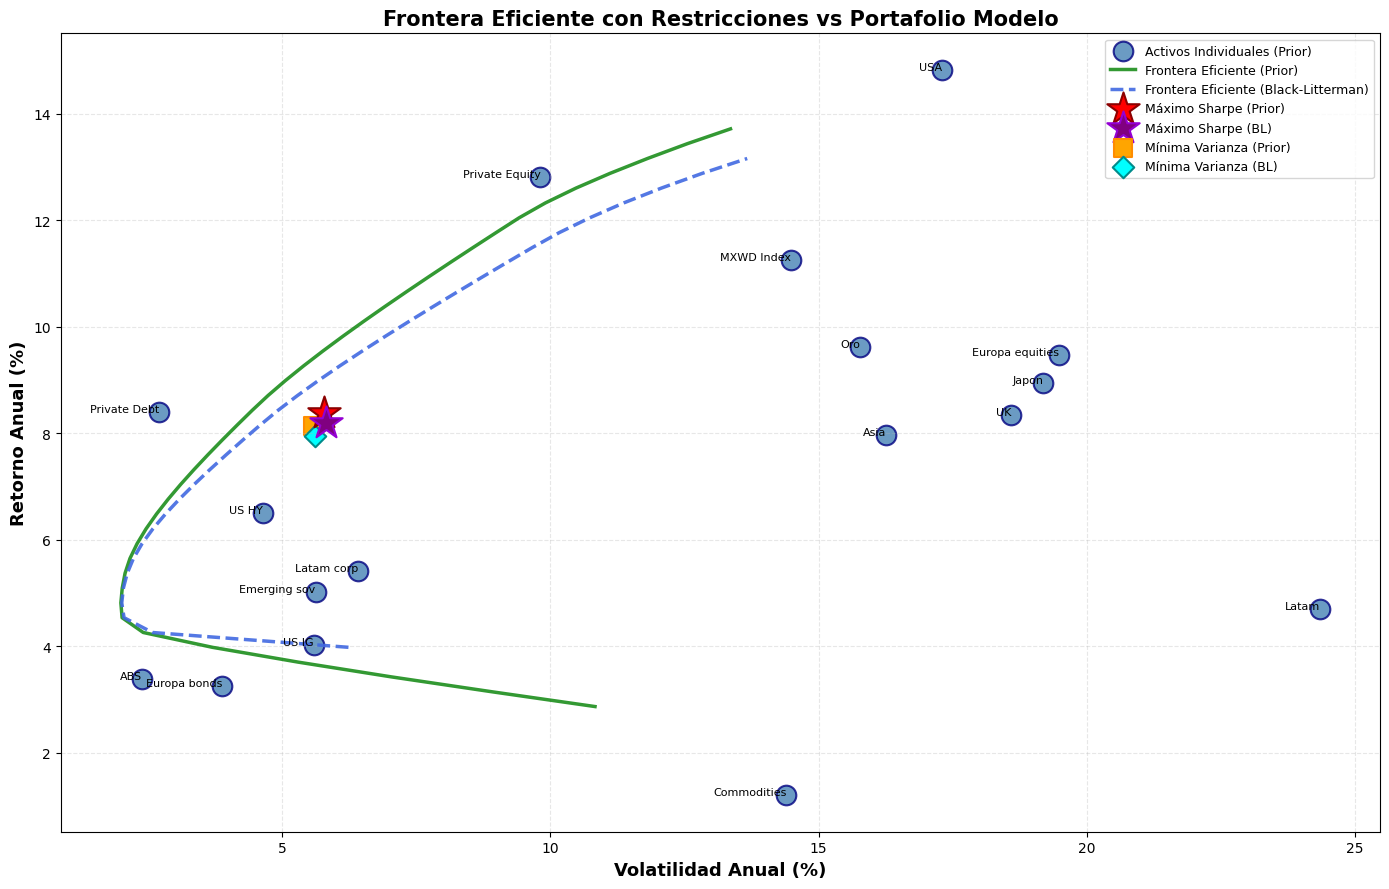


=== COMPARACIÓN DE PONDERACIONES (Máximo Sharpe) ===
                 Modelo (%)  Prior (%)  Black-Litterman (%)  Desv. Prior (pp)  Desv. BL (pp)
Activo                                                                                      
Latam corp             0.00      21.63                21.18             21.63          21.18
USA                    0.00      20.53                20.53             20.53          20.53
US IG                  0.00      14.09                14.09             14.09          14.09
Private Debt          12.59      13.85                13.85              1.26           1.26
Private Equity         6.84       7.52                 7.52              0.68           0.68
Emerging sov           0.00       3.30                 3.30              3.30           3.30
US HY                  0.00       3.29                 3.29              3.29           3.29
Europa bonds           0.00       3.00                 3.00              3.00           3.00
Europa equities 

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ============================================================
# 0) NOMBRES LEGIBLES
# ============================================================
asset_name_map = {
    'MXLA Index': 'Latam',
    'BSELTRUU Index': 'Latam corp',
    'SPX Index': 'USA',
    'LUACTRUU Index': 'US IG',
    'LF98TRUU Index': 'US HY',
    'MXEUG Index': 'Europa equities',
    'LBEATRUH Index': 'Europa bonds',
    'BSSUTRUU Index': 'Emerging sov',
    'MXAPJ Index': 'Asia',
    'MXJP Index': 'Japon',
    'UKX Index': 'UK',
    'GLD US EQUITY': 'Oro',
    'CABS Index': 'ABS',
    'BCOMTR Index': 'Commodities',
    'Private Debt': 'Private Debt',
    'Private Equity': 'Private Equity'
}

def pretty_name(x):
    return asset_name_map.get(x, x)

# ============================================================
# 1) HELPERS (usa las tuyas si ya existen; si no, estas sirven)
# ============================================================
def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = float(np.sum(weights * mean_returns))
    vol = float(np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))))
    return ret, vol

def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.04):
    ret, vol = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe = (ret - risk_free_rate) / vol if vol > 0 else 0.0
    return -sharpe

def min_variance(weights, mean_returns, cov_matrix):
    _, vol = portfolio_performance(weights, mean_returns, cov_matrix)
    return vol

# ============================================================
# 2) FRONTERA EFICIENTE (PRIOR y BL) CON RESTRICCIÓN VS MODELO
# ============================================================
# OJO: esto asume que ya tienes:
# annual_returns (pd.Series), cov_matrix (pd.DataFrame),
# bl_returns (pd.Series), bl_cov (pd.DataFrame),
# opt_sharpe, opt_min_var, opt_sharpe_bl, opt_min_var_bl (resultados minimize),
# portafolio_modelo (dict o Series), max_deviation (float),
# annual_volatility (np.array o pd.Series)

target_returns = np.linspace(float(annual_returns.min()), float(annual_returns.max()), 50)

efficient_volatilities = []
bl_efficient_volatilities = []

universe = list(annual_returns.index)
n_assets = len(universe)

bounds = tuple((0.0, 1.0) for _ in range(n_assets))
init_guess = np.ones(n_assets) / n_assets

# Asegurar modelo como dict para .get()
if isinstance(portafolio_modelo, pd.Series):
    portafolio_modelo_dict = portafolio_modelo.to_dict()
elif isinstance(portafolio_modelo, dict):
    portafolio_modelo_dict = portafolio_modelo
else:
    portafolio_modelo_dict = {}

# Pesos modelo alineados al universo
modelo_pesos = np.array([portafolio_modelo_dict.get(asset, 0.0) for asset in universe], dtype=float)

for target in target_returns:
    # ---------- PRIOR ----------
    constraints_ef = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},
        {'type': 'eq', 'fun': lambda w, t=target: np.sum(w * annual_returns.values) - t},
    ]

    # Restricción banda aditiva vs modelo: w_i ∈ [w_model - max_dev, w_model + max_dev]
    if portafolio_modelo_dict and (max_deviation is not None) and (max_deviation > 0):
        for i in range(n_assets):
            if modelo_pesos[i] > 0:
                lb = max(modelo_pesos[i] - max_deviation, 0.0)
                ub = min(modelo_pesos[i] + max_deviation, 1.0)
                constraints_ef.append({'type': 'ineq', 'fun': lambda w, i=i, lb=lb: w[i] - lb})
                constraints_ef.append({'type': 'ineq', 'fun': lambda w, i=i, ub=ub: ub - w[i]})

    try:
        res = minimize(
            min_variance, init_guess,
            args=(annual_returns.values, cov_matrix.values),
            method='SLSQP', bounds=bounds, constraints=constraints_ef
        )
        if res.success:
            efficient_volatilities.append(portfolio_performance(res.x, annual_returns.values, cov_matrix.values)[1])
        else:
            efficient_volatilities.append(np.nan)
    except Exception:
        efficient_volatilities.append(np.nan)

    # ---------- BLACK-LITTERMAN ----------
    constraints_ef_bl = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},
        {'type': 'eq', 'fun': lambda w, t=target: np.sum(w * bl_returns.reindex(universe).values) - t},
    ]

    if portafolio_modelo_dict and (max_deviation is not None) and (max_deviation > 0):
        for i in range(n_assets):
            if modelo_pesos[i] > 0:
                lb = max(modelo_pesos[i] - max_deviation, 0.0)
                ub = min(modelo_pesos[i] + max_deviation, 1.0)
                constraints_ef_bl.append({'type': 'ineq', 'fun': lambda w, i=i, lb=lb: w[i] - lb})
                constraints_ef_bl.append({'type': 'ineq', 'fun': lambda w, i=i, ub=ub: ub - w[i]})

    try:
        res_bl = minimize(
            min_variance, init_guess,
            args=(bl_returns.reindex(universe).values, bl_cov.values),
            method='SLSQP', bounds=bounds, constraints=constraints_ef_bl
        )
        if res_bl.success:
            bl_efficient_volatilities.append(portfolio_performance(res_bl.x, bl_returns.reindex(universe).values, bl_cov.values)[1])
        else:
            bl_efficient_volatilities.append(np.nan)
    except Exception:
        bl_efficient_volatilities.append(np.nan)

efficient_volatilities = np.array(efficient_volatilities, dtype=float)
bl_efficient_volatilities = np.array(bl_efficient_volatilities, dtype=float)

# Máscaras para plottear solo puntos válidos
mask_prior = np.isfinite(efficient_volatilities)
mask_bl = np.isfinite(bl_efficient_volatilities)

# ============================================================
# 3) GRÁFICO (con nombres legibles)
# ============================================================
plt.figure(figsize=(14, 9))

# Activos individuales (Prior)
plt.scatter(
    np.array(annual_volatility) * 100,
    annual_returns.values * 100,
    s=200, alpha=0.8, c='steelblue',
    marker='o', label='Activos Individuales (Prior)',
    edgecolors='navy', linewidth=1.5
)

for i, asset in enumerate(universe):
    plt.annotate(
        pretty_name(asset),
        (float(annual_volatility[i]) * 100, float(annual_returns.loc[asset]) * 100),
        fontsize=8, ha='right'
    )

# Fronteras (solo si hay datos válidos)
if mask_prior.any():
    plt.plot(
        efficient_volatilities[mask_prior] * 100,
        target_returns[mask_prior] * 100,
        color='green', linewidth=2.5,
        label='Frontera Eficiente (Prior)', alpha=0.8
    )

if mask_bl.any():
    plt.plot(
        bl_efficient_volatilities[mask_bl] * 100,
        target_returns[mask_bl] * 100,
        linestyle='--', color='royalblue',
        linewidth=2.5,
        label='Frontera Eficiente (Black-Litterman)', alpha=0.9
    )

# Puntos óptimos (si existen)
ret_p, vol_p = portfolio_performance(opt_sharpe.x, annual_returns.values, cov_matrix.values)
ret_bl, vol_bl = portfolio_performance(opt_sharpe_bl.x, bl_returns.reindex(universe).values, bl_cov.values)

plt.scatter(vol_p * 100, ret_p * 100, marker='*', color='red', s=600,
            label='Máximo Sharpe (Prior)', edgecolors='darkred', linewidth=1.5, zorder=5)

plt.scatter(vol_bl * 100, ret_bl * 100, marker='*', color='purple', s=600,
            label='Máximo Sharpe (BL)', edgecolors='darkviolet', linewidth=1.5, zorder=5)

ret_mv, vol_mv = portfolio_performance(opt_min_var.x, annual_returns.values, cov_matrix.values)
ret_mv_bl, vol_mv_bl = portfolio_performance(opt_min_var_bl.x, bl_returns.reindex(universe).values, bl_cov.values)

plt.scatter(vol_mv * 100, ret_mv * 100, marker='s', color='orange', s=150,
            label='Mínima Varianza (Prior)', edgecolors='darkorange', linewidth=1.5)

plt.scatter(vol_mv_bl * 100, ret_mv_bl * 100, marker='D', color='cyan', s=120,
            label='Mínima Varianza (BL)', edgecolors='darkcyan', linewidth=1.5)

plt.xlabel('Volatilidad Anual (%)', fontsize=13, fontweight='bold')
plt.ylabel('Retorno Anual (%)', fontsize=13, fontweight='bold')
plt.title('Frontera Eficiente con Restricciones vs Portafolio Modelo', fontsize=15, fontweight='bold')
plt.legend(fontsize=9, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# ============================================================
# 4) PRINT DE PESOS (nombres legibles)
# ============================================================
weights_prior = pd.Series(opt_sharpe.x, index=universe)
weights_bl = pd.Series(opt_sharpe_bl.x, index=universe)

# Modelo en Series alineada al universo ticker
w_model_series = pd.Series(modelo_pesos, index=universe)

comparison_df = pd.DataFrame({
    'Activo': [pretty_name(a) for a in universe],
    'Modelo (%)': (w_model_series.values * 100),
    'Prior (%)': (weights_prior.values * 100),
    'Black-Litterman (%)': (weights_bl.values * 100),
})

comparison_df['Desv. Prior (pp)'] = comparison_df['Prior (%)'] - comparison_df['Modelo (%)']
comparison_df['Desv. BL (pp)'] = comparison_df['Black-Litterman (%)'] - comparison_df['Modelo (%)']

# Filtrar filas irrelevantes y ordenar por BL
comparison_df = (
    comparison_df
    .set_index('Activo')
    .loc[lambda df: df[['Modelo (%)','Prior (%)','Black-Litterman (%)']].abs().sum(axis=1) > 0.1]
    .sort_values('Black-Litterman (%)', ascending=False)
)

print("\n=== COMPARACIÓN DE PONDERACIONES (Máximo Sharpe) ===")
print(comparison_df.round(2).to_string())
